In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
from pathlib import Path
csvpath = Path('AAPL.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-12,27.334999,27.625000,27.165001,27.610001,25.680305,108929200
2016-04-13,27.700001,28.084999,27.700001,28.010000,26.052345,133029200
2016-04-14,27.905001,28.097500,27.832500,28.025000,26.066298,101895600
2016-04-15,28.027500,28.075001,27.432501,27.462500,25.543112,187756000
2016-04-18,27.222500,27.237499,26.735001,26.870001,24.992023,243286000


In [16]:
df['Return'] = df['Close'].pct_change() * 100
df['Lagged_Return'] = df.Return.shift()
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Lagged_Return
Date,,,,,,,,
2016-04-14,27.905001,28.097500,27.832500,28.025000,26.066298,101895600,0.053552,1.448747
2016-04-15,28.027500,28.075001,27.432501,27.462500,25.543112,187756000,-2.007136,0.053552
2016-04-18,27.222500,27.237499,26.735001,26.870001,24.992023,243286000,-2.157484,-2.007136
2016-04-19,26.969999,27.000000,26.557501,26.727501,24.859484,129539600,-0.530331,-2.157484
2016-04-20,26.660000,27.022499,26.514999,26.782499,24.910643,122444000,0.205773,-0.530331


<AxesSubplot:xlabel='Date'>

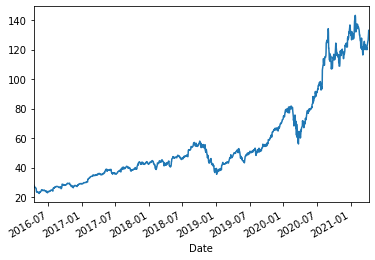

In [17]:
df['Close'].plot()

# Train Test Split Predictions

Training Period: 2001-2018
Testing Period: 2019

In [33]:
# Create a train/test split for the data using 2001-2018 for training and 2019 for testing
train = df['2016':'2018']
test = df['2019']

In [34]:
# Create train and test sets for dependent and independent variables
X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]
X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

In [35]:
# Create and fit model to the data, make predictions
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [36]:
# Construct a dataframe using just the "y" training data:
out_of_sample_results = y_test.to_frame()

# Add a column of "out-of-sample" predictions to that dataframe:  
out_of_sample_results["Out-of-Sample Predictions"] = model.predict(X_test)

In [38]:
# Plot the out-of-sample results for 2019
# out_of_sample_results.plot(subplots=True)

In [39]:
# Calculate out-of-sample mean_squared_error (for comparison to out-of-sample)
out_of_sample_mse = mean_squared_error(
    out_of_sample_results["Return"],
    out_of_sample_results["Out-of-Sample Predictions"]
)

# Calculate out-of-sample root mean_squared_error (for comparison to out-of-sample)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 1.672295224745903


# Rolling Out-of-Sample Predictions

In [24]:
# Split the index into weekly periods
weeks = df.index.to_period("w").unique()
print(weeks[0])

2016-04-11/2016-04-17


In [25]:
# Declare the training window of 12 weeks
# Define the imeframe of rolling windows
training_window = 12
timeframe = len(weeks) - training_window - 1
print(timeframe)

248


In [26]:
# Construct empty placeholder dataframes.
# (During each iteration of the loop, we'll append that week"s predictions to this DataFrame)
all_predictions = pd.DataFrame(columns=["Out-of-Sample Predictions"])
all_actuals = pd.DataFrame(columns=["Actual Returns"])

In [27]:
# During rolling iteration, split into train and test sets.
# Use linear regression to make out-of-sample predictions.
# Append the results to external dataframes.
for i in range(0, timeframe):
    
    # Beginning of training window
    start_of_training_period = weeks[i].start_time.strftime(format="%Y-%m-%d")
    
    # End of training window
    end_of_training_period = weeks[training_window+i].end_time.strftime(format="%Y-%m-%d")

    # Window of test-window data
    test_week = weeks[training_window + i + 1]
    
    # String of testing window
    start_of_test_week  = test_week.start_time.strftime(format="%Y-%m-%d")
    end_of_test_week = test_week.end_time.strftime(format="%Y-%m-%d")
    
    train = df.loc[start_of_training_period:end_of_training_period]
    test = df.loc[start_of_test_week:end_of_test_week]
    
    # Create new dataframes:
    X_train = train["Lagged_Return"].to_frame()
    y_train = train["Return"]
    X_test = test["Lagged_Return"].to_frame()
    y_test = test["Return"]

    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Create a temporary dataframe to hold predictions
    predictions = pd.DataFrame(predictions, index=X_test.index, columns=["Out-of-Sample Predictions"])
    
    # Create a temporary DataFrame of the actual "y"s in the test dataframe, with column name="Actual Returns": 
    actuals = pd.DataFrame(y_test, index=y_test.index)
    actuals.columns = ["Actual Returns"]  
    
    # Append these two dataframes (predictions and actuals) to the two master DataFrames built outside the loop
    all_predictions = all_predictions.append(predictions)
    all_actuals = all_actuals.append(actuals)   
    

In [28]:
Results = pd.concat([all_actuals, all_predictions], axis=1)
Results.head()

,Actual Returns,Out-of-Sample Predictions
2016-07-11,0.310306,0.077831
2016-07-12,0.453698,-0.067076
2016-07-13,-0.564562,-0.022004
2016-07-14,1.982034,-0.342073
2016-07-15,-0.010122,0.458397


In [44]:
# 2019 Data
results_2019 = Results.loc['2019':]
results_2019.head()

,Actual Returns,Out-of-Sample Predictions
2019-01-02,0.114109,-0.657414
2019-01-03,-9.960737,-0.602742
2019-01-04,4.268930,0.043423
2019-01-07,-0.222585,-1.479679
2019-01-08,1.906313,-0.720698


In [43]:
# Plot the results
# results_2019.plot(subplots=True)

In [41]:
# Out-of-sample metrics
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe above)
mse = mean_squared_error(
    results_2019["Actual Returns"],
    results_2019["Out-of-Sample Predictions"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rolling_rmse = np.sqrt(mse)
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

Rolling Out-of-Sample Root Mean Squared Error (RMSE): 2.3367560823354103


# Final Model Comparison

In [42]:
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")
print(f"Rolling Out-of-Sample Root Mean Squared Error (RMSE): {rolling_rmse}")

Out-of-sample Root Mean Squared Error (RMSE): 1.672295224745903
Rolling Out-of-Sample Root Mean Squared Error (RMSE): 2.3367560823354103


Comparing the two RMSE's, the RMSE from the single training window is 0.73, whereas it is 0.75 from the rolling-out-of-sample model.

* The rolling-out-of sample approach is an approach more akin to real life (you likely re-estimate your model when new data becomes available)
* In addition to being more realistic, the rolling-out of sample approach is also more rigorous, as you are testing your model many more times across different time periods
* Therefore, we expect a slightly higher out-of-sample RMSE, which is what we see.
* The fact that the two are close to each other in value though does suggest that our model is reasonably stable.